## Keras using word embedding + convolutional NN + random search cross-validation

First, lets import the library folder of the virtual environment. This allow us to work inside this notebook.

In [1]:
import sys
import os
sys.path.append(os.getcwd()+'/venv/lib/python3.6/site-packages/')

#### Loading data

In [2]:
import pandas as pd

datafile = {'pasivos': 'data/pasivos.csv','detractores': 'data/detractores.csv'}

df_list = []
for data, file in datafile.items():
    df = pd.read_csv(file)
    df['class'] = data
    df_list.append(df.fillna(0))


#### Output categories

In [3]:
categories = ['servicio ripley','mayor saldo','falta informacion',
           'aumentar cant trans','performance','formas de carga',
           'usabilidad','puntos ripley','cumplir promociones',
           'mejorar beneficios','premiar app','nuevo',
           'atencion al cliente','seguridad','transacciones diarias',
           'datos usuario','huawei']

for data in df_list:
    for cat in categories:
        data[cat] = pd.to_numeric(data[cat])

#### Plotting data for each category

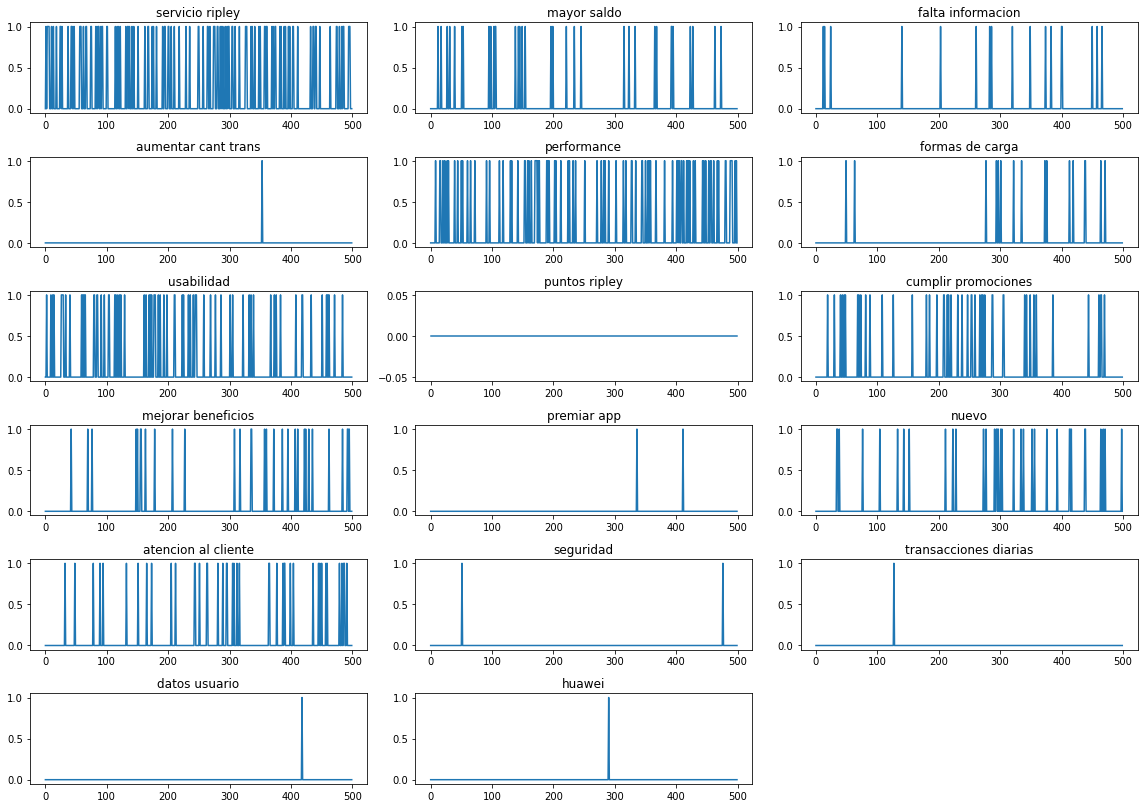

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(int(np.ceil(len(categories)/3)),3,figsize=(16,2*len(categories)/3))

for i,cat in enumerate(categories):
    if (data[cat] == None).any():
        print('fuck')
    axs[int(i/3)][i%3].plot(range(len(data[cat])),data[cat])
    axs[int(i/3)][i%3].set_title(cat)
    
fig.delaxes(axs[-1][-1])
plt.tight_layout()

#### Performing logistic regression over each data
Separates data in train and test.
During the process, the texts are vectorized using a bag of words approach.

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)


mLen = 300

data = df_list[0] # uses only 'pasivos' to construct each model
secondaryTestData = df_list[1]
isSecData = type(secondaryTestData) == pd.core.frame.DataFrame

def tokenizeAndPad(tokenizer,text,maxLen=mLen):
    # The tokenizer exchange each word by an index, creating vectors filled with word indexes
    tokenized = tokenizer.texts_to_sequences(text)
    # Padding fixes the lenght of each sentence (vector) to mLen adding zeros if necessary
    return pad_sequences(tokenized, padding='post', maxlen=maxLen)
    

exp = []
for cat in categories:
    print('\n--> '+cat,)
    if (data[cat]==0).all() or sum(data[cat]) <= 1:
        print('**\tNot enough data\t**')
        continue
    
    text_tr, text_te, y_tr, y_te = train_test_split(data['texto'], data[cat], test_size=0.25, random_state=1000)
    
    tokenizer.fit_on_texts(text_tr)
    
    exp.append( {'exp'    : cat, 
                 'itrain' : tokenizeAndPad(tokenizer,text_tr), 
                 'itest'  : tokenizeAndPad(tokenizer,text_te),
                 'otrain' : y_tr, 
                 'otest'  : y_te,
                 'length' : mLen,
                 'wIndex' : tokenizer.word_index
                })

    if isSecData:
        exp[-1]['sec_itest'] = tokenizeAndPad(tokenizer,secondaryTestData['texto'])
        exp[-1]['sec_otest'] = secondaryTestData[cat]

/home/cristobal/Dropbox/text-classifier/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cristobal/Dropbox/text-classifier/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cristobal/Dropbox/text-classifier/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cristobal/


--> servicio ripley

--> mayor saldo

--> falta informacion

--> aumentar cant trans

--> performance

--> formas de carga

--> usabilidad

--> puntos ripley

--> cumplir promociones

--> mejorar beneficios

--> premiar app

--> nuevo

--> atencion al cliente

--> seguridad

--> transacciones diarias

--> datos usuario

--> huawei
**	Not enough data	**


#### Running keras

Layers settings

In [13]:
useMaxPooling = True   # Use max pooling to embedded inputs
useCNN = True          # Use convolutional neural networks
useCV  = True          # Use cross-validation
usePreEmbedding = False# Use word embedding trained from wikipedia

experimentsName = 'keras_wE' + \
                   ('_CNN' if useCNN else '') + \
                   ('_CV' if useCV else '') + \
                   ('_pE' if useCV else '') + \
                   ('_mP' if useMaxPooling else '')


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import numpy as np

if useCV:
    from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
    from sklearn.model_selection import RandomizedSearchCV

nExp = str(len(exp))

lEmbedding = 100
params = { 'nfilter': [32, 64, 128], 'nkernel': [3, 5, 7] }
epochs = 100
batchSize = 10
pre_embeddingsFile = '/home/cristobal/Downloads/wiki.es.vec'
trainPreEmbeddings = True

if usePreEmbedding:
    pre_embeddingsFile = open(pre_embeddingsFile)
    
    def filterEmbedding(wIndex, eFile=pre_embeddingsFile, embLen = lEmbedding):
        eMatrix = np.zeros((len(wIndex)+1,embLen))
        
        eFile.seek(0)
        # with open(eFile) as inputEmbedding:
        for row in eFile:
            w, *v = row.split()
            if w in wIndex:
                eMatrix[wIndex[w]] = np.arrray(v, dtype=np.float32)[:lEmbedding]
        return eMatrix

def newModel(exp,nfilter=params['nfilter'][2], nkernel=params['nkernel'][1], preEmb=usePreEmbedding, embLen=lEmbedding):
    modelName = exp['exp']+' f:'+str(nfilter) + ' k:'+str(nkernel)
    vSize = len(e['wIndex'])+1
    
    model = Sequential(name = modelName)
    if preEmb:
        model.add(layers.Embedding(vSize,
                                   embLen,
                                   weights=filterEmbedding(exp['wIndex']),
                                   input_length=exp['length'],
                                   trainable=trainPreEmbeddings,
                                  ))
    else:
        model.add(layers.Embedding(vSize,embLen, input_length=exp['length']))
    if useCNN:
        model.add(layers.Conv1D(nfilter, nkernel, activation='relu'))
    if useMaxPooling:
        model.add(layers.GlobalMaxPool1D())
    else:
        model.add(layers.Flatten())
    model.add(layers.Dense(10,activation='relu'))
    model.add(layers.Dense(1,activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model
    
for i,e in enumerate(exp):
    iDim = e['itrain'].shape[1]
    print(e['exp'])
    if useCV:
        def modelWrapper(nfilter, nkernel,exp=e):
            return newModel(exp,nfilter,nkernel)
            
        kclass = KerasClassifier(build_fn=modelWrapper,
                                 epochs=epochs,
                                 batch_size=batchSize,
                                 verbose=False
                                 )
        
        e['model'] = RandomizedSearchCV(estimator=kclass,
                                        param_distributions=params,
                                        cv=4,
                                        n_iter=5,
                                        verbose=1,
                                        )
        
        e['history'] = e['model'].fit(e['itrain'],e['otrain'])        
        
        print('\n\n**** '+e['exp']+' best params: ',e['history'].best_params_,' **** \n\n')
        
    else:
        e['model'] = newModel(e)

        e['history'] = e['model'].fit(e['itrain'], 
                                      e['otrain'],
                                      epochs=epochs,
                                      verbose=False,
                                      validation_data=(e['itest'], e['otest']),
                                      batch_size=batchSize
                                     )
    
if usePreEmbedding:
    close(pre_embeddingsFile)

servicio ripley
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Model: "servicio ripley f:64 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 300, 100)          101900    
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 294, 64)           44864     
_________________________________________________________________
global_max_pooling1d_40 (Glo (None, 64)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 11        
Total params: 147,425
Trainable params: 147,425
Non-trainable params: 0
_________________________________________________________________
Model: "servicio ripley f:

Model: "servicio ripley f:128 k:3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     (None, 300, 100)          101900    
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 298, 128)          38528     
_________________________________________________________________
global_max_pooling1d_48 (Glo (None, 128)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 11        
Total params: 141,729
Trainable params: 141,729
Non-trainable params: 0
_________________________________________________________________
Model: "servicio ripley f:128 k:3"
_________________________________________________________________


Model: "servicio ripley f:64 k:5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_56 (Embedding)     (None, 300, 100)          101900    
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 296, 64)           32064     
_________________________________________________________________
global_max_pooling1d_56 (Glo (None, 64)                0         
_________________________________________________________________
dense_112 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 11        
Total params: 134,625
Trainable params: 134,625
Non-trainable params: 0
_________________________________________________________________
Model: "servicio ripley f:64 k:5"
_________________________________________________________________
La

Model: "mayor saldo f:64 k:3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_64 (Embedding)     (None, 300, 100)          101900    
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 298, 64)           19264     
_________________________________________________________________
global_max_pooling1d_64 (Glo (None, 64)                0         
_________________________________________________________________
dense_128 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 11        
Total params: 121,825
Trainable params: 121,825
Non-trainable params: 0
_________________________________________________________________
Model: "mayor saldo f:32 k:5"
_________________________________________________________________
Layer (typ

Model: "mayor saldo f:32 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_72 (Embedding)     (None, 300, 100)          101900    
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 294, 32)           22432     
_________________________________________________________________
global_max_pooling1d_72 (Glo (None, 32)                0         
_________________________________________________________________
dense_144 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 11        
Total params: 124,673
Trainable params: 124,673
Non-trainable params: 0
_________________________________________________________________
Model: "mayor saldo f:32 k:3"
_________________________________________________________________
Layer (typ

Model: "mayor saldo f:64 k:5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_80 (Embedding)     (None, 300, 100)          101900    
_________________________________________________________________
conv1d_80 (Conv1D)           (None, 296, 64)           32064     
_________________________________________________________________
global_max_pooling1d_80 (Glo (None, 64)                0         
_________________________________________________________________
dense_160 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_161 (Dense)            (None, 1)                 11        
Total params: 134,625
Trainable params: 134,625
Non-trainable params: 0
_________________________________________________________________
Model: "mayor saldo f:64 k:3"
_________________________________________________________________
Layer (typ

Model: "falta informacion f:64 k:3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_88 (Embedding)     (None, 300, 100)          101900    
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 298, 64)           19264     
_________________________________________________________________
global_max_pooling1d_88 (Glo (None, 64)                0         
_________________________________________________________________
dense_176 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_177 (Dense)            (None, 1)                 11        
Total params: 121,825
Trainable params: 121,825
Non-trainable params: 0
_________________________________________________________________
Model: "falta informacion f:64 k:3"
________________________________________________________________

Model: "falta informacion f:64 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_96 (Embedding)     (None, 300, 100)          101900    
_________________________________________________________________
conv1d_96 (Conv1D)           (None, 294, 64)           44864     
_________________________________________________________________
global_max_pooling1d_96 (Glo (None, 64)                0         
_________________________________________________________________
dense_192 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_193 (Dense)            (None, 1)                 11        
Total params: 147,425
Trainable params: 147,425
Non-trainable params: 0
_________________________________________________________________
Model: "falta informacion f:64 k:7"
________________________________________________________________

Model: "aumentar cant trans f:32 k:5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_104 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_104 (Conv1D)          (None, 296, 32)           16032     
_________________________________________________________________
global_max_pooling1d_104 (Gl (None, 32)                0         
_________________________________________________________________
dense_208 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_209 (Dense)            (None, 1)                 11        
Total params: 118,273
Trainable params: 118,273
Non-trainable params: 0
_________________________________________________________________
Model: "aumentar cant trans f:32 k:5"
____________________________________________________________

Model: "aumentar cant trans f:128 k:5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_112 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 296, 128)          64128     
_________________________________________________________________
global_max_pooling1d_112 (Gl (None, 128)               0         
_________________________________________________________________
dense_224 (Dense)            (None, 10)                1290      
_________________________________________________________________
dense_225 (Dense)            (None, 1)                 11        
Total params: 167,329
Trainable params: 167,329
Non-trainable params: 0
_________________________________________________________________
Model: "aumentar cant trans f:128 k:5"
__________________________________________________________

Model: "aumentar cant trans f:128 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_120 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_120 (Conv1D)          (None, 294, 128)          89728     
_________________________________________________________________
global_max_pooling1d_120 (Gl (None, 128)               0         
_________________________________________________________________
dense_240 (Dense)            (None, 10)                1290      
_________________________________________________________________
dense_241 (Dense)            (None, 1)                 11        
Total params: 192,929
Trainable params: 192,929
Non-trainable params: 0
_________________________________________________________________
Model: "aumentar cant trans f:128 k:7"
__________________________________________________________

Model: "performance f:32 k:5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_128 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 296, 32)           16032     
_________________________________________________________________
global_max_pooling1d_128 (Gl (None, 32)                0         
_________________________________________________________________
dense_256 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_257 (Dense)            (None, 1)                 11        
Total params: 118,273
Trainable params: 118,273
Non-trainable params: 0
_________________________________________________________________
Model: "performance f:32 k:5"
_________________________________________________________________
Layer (typ

Model: "performance f:32 k:3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_136 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_136 (Conv1D)          (None, 298, 32)           9632      
_________________________________________________________________
global_max_pooling1d_136 (Gl (None, 32)                0         
_________________________________________________________________
dense_272 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_273 (Dense)            (None, 1)                 11        
Total params: 111,873
Trainable params: 111,873
Non-trainable params: 0
_________________________________________________________________
Model: "performance f:32 k:3"
_________________________________________________________________
Layer (typ

Model: "performance f:64 k:3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_144 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_144 (Conv1D)          (None, 298, 64)           19264     
_________________________________________________________________
global_max_pooling1d_144 (Gl (None, 64)                0         
_________________________________________________________________
dense_288 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_289 (Dense)            (None, 1)                 11        
Total params: 121,825
Trainable params: 121,825
Non-trainable params: 0
_________________________________________________________________


**** performance best params:  {'nkernel': 3, 'nfilter': 64}  **** 


formas de carga
Fitting 4 folds fo

Model: "formas de carga f:128 k:5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_152 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 296, 128)          64128     
_________________________________________________________________
global_max_pooling1d_152 (Gl (None, 128)               0         
_________________________________________________________________
dense_304 (Dense)            (None, 10)                1290      
_________________________________________________________________
dense_305 (Dense)            (None, 1)                 11        
Total params: 167,329
Trainable params: 167,329
Non-trainable params: 0
_________________________________________________________________
Model: "formas de carga f:64 k:7"
_________________________________________________________________
L

Model: "formas de carga f:32 k:5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_160 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_160 (Conv1D)          (None, 296, 32)           16032     
_________________________________________________________________
global_max_pooling1d_160 (Gl (None, 32)                0         
_________________________________________________________________
dense_320 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_321 (Dense)            (None, 1)                 11        
Total params: 118,273
Trainable params: 118,273
Non-trainable params: 0
_________________________________________________________________
Model: "formas de carga f:64 k:5"
_________________________________________________________________
La

Model: "usabilidad f:32 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_168 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_168 (Conv1D)          (None, 294, 32)           22432     
_________________________________________________________________
global_max_pooling1d_168 (Gl (None, 32)                0         
_________________________________________________________________
dense_336 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_337 (Dense)            (None, 1)                 11        
Total params: 124,673
Trainable params: 124,673
Non-trainable params: 0
_________________________________________________________________
Model: "usabilidad f:32 k:7"
_________________________________________________________________
Layer (type)

Model: "usabilidad f:128 k:3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_176 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_176 (Conv1D)          (None, 298, 128)          38528     
_________________________________________________________________
global_max_pooling1d_176 (Gl (None, 128)               0         
_________________________________________________________________
dense_352 (Dense)            (None, 10)                1290      
_________________________________________________________________
dense_353 (Dense)            (None, 1)                 11        
Total params: 141,729
Trainable params: 141,729
Non-trainable params: 0
_________________________________________________________________
Model: "usabilidad f:128 k:3"
_________________________________________________________________
Layer (typ

Model: "usabilidad f:64 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_184 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 294, 64)           44864     
_________________________________________________________________
global_max_pooling1d_184 (Gl (None, 64)                0         
_________________________________________________________________
dense_368 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_369 (Dense)            (None, 1)                 11        
Total params: 147,425
Trainable params: 147,425
Non-trainable params: 0
_________________________________________________________________
Model: "usabilidad f:64 k:7"
_________________________________________________________________
Layer (type)

Model: "puntos ripley f:128 k:3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_192 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_192 (Conv1D)          (None, 298, 128)          38528     
_________________________________________________________________
global_max_pooling1d_192 (Gl (None, 128)               0         
_________________________________________________________________
dense_384 (Dense)            (None, 10)                1290      
_________________________________________________________________
dense_385 (Dense)            (None, 1)                 11        
Total params: 141,729
Trainable params: 141,729
Non-trainable params: 0
_________________________________________________________________
Model: "puntos ripley f:128 k:3"
_________________________________________________________________
Laye

Model: "puntos ripley f:64 k:5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_200 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_200 (Conv1D)          (None, 296, 64)           32064     
_________________________________________________________________
global_max_pooling1d_200 (Gl (None, 64)                0         
_________________________________________________________________
dense_400 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_401 (Dense)            (None, 1)                 11        
Total params: 134,625
Trainable params: 134,625
Non-trainable params: 0
_________________________________________________________________
Model: "puntos ripley f:64 k:5"
_________________________________________________________________
Layer 



**** puntos ripley best params:  {'nkernel': 5, 'nfilter': 32}  **** 


cumplir promociones
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Model: "cumplir promociones f:64 k:3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_208 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_208 (Conv1D)          (None, 298, 64)           19264     
_________________________________________________________________
global_max_pooling1d_208 (Gl (None, 64)                0         
_________________________________________________________________
dense_416 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_417 (Dense)            (None, 1)                 11        
Total params: 121,825
Trainable params: 121,825
Non-trainable params: 0
__________

Model: "cumplir promociones f:32 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_216 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_216 (Conv1D)          (None, 294, 32)           22432     
_________________________________________________________________
global_max_pooling1d_216 (Gl (None, 32)                0         
_________________________________________________________________
dense_432 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_433 (Dense)            (None, 1)                 11        
Total params: 124,673
Trainable params: 124,673
Non-trainable params: 0
_________________________________________________________________
Model: "cumplir promociones f:32 k:7"
____________________________________________________________

Model: "cumplir promociones f:32 k:5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_224 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_224 (Conv1D)          (None, 296, 32)           16032     
_________________________________________________________________
global_max_pooling1d_224 (Gl (None, 32)                0         
_________________________________________________________________
dense_448 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_449 (Dense)            (None, 1)                 11        
Total params: 118,273
Trainable params: 118,273
Non-trainable params: 0
_________________________________________________________________
Model: "cumplir promociones f:32 k:5"
____________________________________________________________

Model: "mejorar beneficios f:64 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_232 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_232 (Conv1D)          (None, 294, 64)           44864     
_________________________________________________________________
global_max_pooling1d_232 (Gl (None, 64)                0         
_________________________________________________________________
dense_464 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_465 (Dense)            (None, 1)                 11        
Total params: 147,425
Trainable params: 147,425
Non-trainable params: 0
_________________________________________________________________
Model: "mejorar beneficios f:128 k:5"
_____________________________________________________________

Model: "mejorar beneficios f:32 k:3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_240 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_240 (Conv1D)          (None, 298, 32)           9632      
_________________________________________________________________
global_max_pooling1d_240 (Gl (None, 32)                0         
_________________________________________________________________
dense_480 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_481 (Dense)            (None, 1)                 11        
Total params: 111,873
Trainable params: 111,873
Non-trainable params: 0
_________________________________________________________________
Model: "mejorar beneficios f:32 k:5"
______________________________________________________________

Model: "mejorar beneficios f:128 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_248 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_248 (Conv1D)          (None, 294, 128)          89728     
_________________________________________________________________
global_max_pooling1d_248 (Gl (None, 128)               0         
_________________________________________________________________
dense_496 (Dense)            (None, 10)                1290      
_________________________________________________________________
dense_497 (Dense)            (None, 1)                 11        
Total params: 192,929
Trainable params: 192,929
Non-trainable params: 0
_________________________________________________________________
Model: "mejorar beneficios f:64 k:7"
_____________________________________________________________

Model: "premiar app f:32 k:5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_256 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_256 (Conv1D)          (None, 296, 32)           16032     
_________________________________________________________________
global_max_pooling1d_256 (Gl (None, 32)                0         
_________________________________________________________________
dense_512 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_513 (Dense)            (None, 1)                 11        
Total params: 118,273
Trainable params: 118,273
Non-trainable params: 0
_________________________________________________________________
Model: "premiar app f:32 k:5"
_________________________________________________________________
Layer (typ

Model: "premiar app f:32 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_264 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_264 (Conv1D)          (None, 294, 32)           22432     
_________________________________________________________________
global_max_pooling1d_264 (Gl (None, 32)                0         
_________________________________________________________________
dense_528 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_529 (Dense)            (None, 1)                 11        
Total params: 124,673
Trainable params: 124,673
Non-trainable params: 0
_________________________________________________________________
Model: "premiar app f:32 k:7"
_________________________________________________________________
Layer (typ

Model: "nuevo f:32 k:5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_272 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_272 (Conv1D)          (None, 296, 32)           16032     
_________________________________________________________________
global_max_pooling1d_272 (Gl (None, 32)                0         
_________________________________________________________________
dense_544 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_545 (Dense)            (None, 1)                 11        
Total params: 118,273
Trainable params: 118,273
Non-trainable params: 0
_________________________________________________________________
Model: "nuevo f:32 k:5"
_________________________________________________________________
Layer (type)          

Model: "nuevo f:128 k:5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_281 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_281 (Conv1D)          (None, 296, 128)          64128     
_________________________________________________________________
global_max_pooling1d_281 (Gl (None, 128)               0         
_________________________________________________________________
dense_562 (Dense)            (None, 10)                1290      
_________________________________________________________________
dense_563 (Dense)            (None, 1)                 11        
Total params: 167,329
Trainable params: 167,329
Non-trainable params: 0
_________________________________________________________________
Model: "nuevo f:128 k:5"
_________________________________________________________________
Layer (type)        

Model: "nuevo f:32 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_290 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_290 (Conv1D)          (None, 294, 32)           22432     
_________________________________________________________________
global_max_pooling1d_290 (Gl (None, 32)                0         
_________________________________________________________________
dense_580 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_581 (Dense)            (None, 1)                 11        
Total params: 124,673
Trainable params: 124,673
Non-trainable params: 0
_________________________________________________________________
Model: "nuevo f:128 k:3"
_________________________________________________________________
Layer (type)         

Model: "atencion al cliente f:32 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_298 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_298 (Conv1D)          (None, 294, 32)           22432     
_________________________________________________________________
global_max_pooling1d_298 (Gl (None, 32)                0         
_________________________________________________________________
dense_596 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_597 (Dense)            (None, 1)                 11        
Total params: 124,673
Trainable params: 124,673
Non-trainable params: 0
_________________________________________________________________
Model: "atencion al cliente f:32 k:7"
____________________________________________________________

Model: "atencion al cliente f:32 k:5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_306 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_306 (Conv1D)          (None, 296, 32)           16032     
_________________________________________________________________
global_max_pooling1d_306 (Gl (None, 32)                0         
_________________________________________________________________
dense_612 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_613 (Dense)            (None, 1)                 11        
Total params: 118,273
Trainable params: 118,273
Non-trainable params: 0
_________________________________________________________________
Model: "atencion al cliente f:32 k:5"
____________________________________________________________

Model: "seguridad f:32 k:5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_314 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_314 (Conv1D)          (None, 296, 32)           16032     
_________________________________________________________________
global_max_pooling1d_314 (Gl (None, 32)                0         
_________________________________________________________________
dense_628 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_629 (Dense)            (None, 1)                 11        
Total params: 118,273
Trainable params: 118,273
Non-trainable params: 0
_________________________________________________________________
Model: "seguridad f:32 k:5"
_________________________________________________________________
Layer (type)  

Model: "seguridad f:64 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_322 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_322 (Conv1D)          (None, 294, 64)           44864     
_________________________________________________________________
global_max_pooling1d_322 (Gl (None, 64)                0         
_________________________________________________________________
dense_644 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_645 (Dense)            (None, 1)                 11        
Total params: 147,425
Trainable params: 147,425
Non-trainable params: 0
_________________________________________________________________
Model: "seguridad f:64 k:7"
_________________________________________________________________
Layer (type)  

Model: "seguridad f:32 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_330 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_330 (Conv1D)          (None, 294, 32)           22432     
_________________________________________________________________
global_max_pooling1d_330 (Gl (None, 32)                0         
_________________________________________________________________
dense_660 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_661 (Dense)            (None, 1)                 11        
Total params: 124,673
Trainable params: 124,673
Non-trainable params: 0
_________________________________________________________________
Model: "seguridad f:32 k:7"
_________________________________________________________________
Layer (type)  

Model: "transacciones diarias f:64 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_338 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_338 (Conv1D)          (None, 294, 64)           44864     
_________________________________________________________________
global_max_pooling1d_338 (Gl (None, 64)                0         
_________________________________________________________________
dense_676 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_677 (Dense)            (None, 1)                 11        
Total params: 147,425
Trainable params: 147,425
Non-trainable params: 0
_________________________________________________________________
Model: "transacciones diarias f:64 k:7"
________________________________________________________

Model: "transacciones diarias f:64 k:3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_346 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_346 (Conv1D)          (None, 298, 64)           19264     
_________________________________________________________________
global_max_pooling1d_346 (Gl (None, 64)                0         
_________________________________________________________________
dense_692 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_693 (Dense)            (None, 1)                 11        
Total params: 121,825
Trainable params: 121,825
Non-trainable params: 0
_________________________________________________________________
Model: "transacciones diarias f:64 k:3"
________________________________________________________

Model: "transacciones diarias f:64 k:7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_354 (Embedding)    (None, 300, 100)          101900    
_________________________________________________________________
conv1d_354 (Conv1D)          (None, 294, 64)           44864     
_________________________________________________________________
global_max_pooling1d_354 (Gl (None, 64)                0         
_________________________________________________________________
dense_708 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_709 (Dense)            (None, 1)                 11        
Total params: 147,425
Trainable params: 147,425
Non-trainable params: 0
_________________________________________________________________


**** transacciones diarias best params:  {'nkernel': 7, 'nfilter': 64}  **** 


datos usuario


##### Evaluating model

In [15]:
from sklearn.metrics import confusion_matrix

def evaluateModel(iDict,sDict,iData,oData,threshold=0.5):
    sDict['prediction']  = [val[0] > threshold for val in iDict['model'].predict(iData)]
    sDict['truth']       = oData
    sDict['confusion']   = confusion_matrix(sDict['truth'],sDict['prediction'])
    
    if len(sDict['confusion']) > 1:
        sDict['tp']             = sDict['confusion'][1][1]
        sDict['tn']             = sDict['confusion'][0][0]
        sDict['fp']             = sDict['confusion'][0][1]
        sDict['fn']             = sDict['confusion'][1][0]
        sDict['N' ]             = np.sum(sDict['confusion'])
        
        sDict['accuracy' ] = (sDict['tn']+sDict['tp']) / sDict['N']
        sDict['precision'] = sDict['tp'] / (sDict['tp']+sDict['fp'])
        sDict['recall'   ] = sDict['tp'] / (sDict['tp']+sDict['fn'])
    
        print('Accuracy:',sDict['accuracy'])
        print('Precision:',sDict['precision'])
        print('Recall:',sDict['recall'])

for e in exp:    
    print('\n-->',e['exp'])
    evaluateModel(e,e,e['itest'],e['otest'])
    
print('\nChecking for secondary test data ...\n')
for e in exp:    
    if 'sec_itest' in  e:
        print('\n-->',e['exp'])
        e['secondaryTest'] = {}
        evaluateModel(e,e['secondaryTest'],e['sec_itest'],e['sec_otest'])
        



--> servicio ripley
Accuracy: 0.7926829268292683
Precision: 0.5384615384615384
Recall: 0.3888888888888889

--> mayor saldo
Accuracy: 0.9146341463414634
Precision: 0.6666666666666666
Recall: 0.4444444444444444

--> falta informacion
Accuracy: 0.9512195121951219
Precision: nan
Recall: 0.0

--> aumentar cant trans

--> performance


/home/cristobal/Dropbox/text-classifier/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/cristobal/Dropbox/text-classifier/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


Accuracy: 0.8292682926829268
Precision: 0.6428571428571429
Recall: 0.5

--> formas de carga
Accuracy: 0.9878048780487805
Precision: 0.0
Recall: nan

--> usabilidad
Accuracy: 0.8536585365853658
Precision: 0.6666666666666666
Recall: 0.2857142857142857

--> puntos ripley

--> cumplir promociones
Accuracy: 0.9878048780487805
Precision: nan
Recall: 0.0

--> mejorar beneficios


/home/cristobal/Dropbox/text-classifier/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/cristobal/Dropbox/text-classifier/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


Accuracy: 0.8170731707317073
Precision: 0.6428571428571429
Recall: 0.47368421052631576

--> premiar app
Accuracy: 0.8780487804878049
Precision: 0.3333333333333333
Recall: 0.6666666666666666

--> nuevo
Accuracy: 0.9146341463414634
Precision: 0.8
Recall: 0.4

--> atencion al cliente
Accuracy: 0.9634146341463414
Precision: nan
Recall: 0.0

--> seguridad
Accuracy: 0.975609756097561
Precision: nan
Recall: 0.0

--> transacciones diarias


/home/cristobal/Dropbox/text-classifier/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/cristobal/Dropbox/text-classifier/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


Accuracy: 0.9878048780487805
Precision: nan
Recall: 0.0

--> datos usuario

Checking for secondary test data ...


--> servicio ripley
Accuracy: 0.786
Precision: 0.6176470588235294
Recall: 0.34146341463414637

--> mayor saldo
Accuracy: 0.946
Precision: 0.8181818181818182
Recall: 0.2647058823529412

--> falta informacion
Accuracy: 0.962
Precision: 0.0
Recall: 0.0

--> aumentar cant trans


/home/cristobal/Dropbox/text-classifier/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


Accuracy: 0.998
Precision: nan
Recall: 0.0

--> performance
Accuracy: 0.802
Precision: 0.4647887323943662
Recall: 0.35106382978723405

--> formas de carga
Accuracy: 0.964
Precision: 0.0
Recall: 0.0

--> usabilidad
Accuracy: 0.862
Precision: 0.6923076923076923
Recall: 0.12162162162162163

--> puntos ripley

--> cumplir promociones
Accuracy: 0.91
Precision: 0.75
Recall: 0.06382978723404255

--> mejorar beneficios
Accuracy: 0.868
Precision: 0.2033898305084746
Recall: 0.3870967741935484

--> premiar app
Accuracy: 0.97
Precision: 0.0
Recall: 0.0

--> nuevo
Accuracy: 0.924
Precision: 0.4444444444444444
Recall: 0.34285714285714286

--> atencion al cliente
Accuracy: 0.918
Precision: 0.75
Recall: 0.06976744186046512

--> seguridad


/home/cristobal/Dropbox/text-classifier/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


Accuracy: 0.996
Precision: nan
Recall: 0.0

--> transacciones diarias


/home/cristobal/Dropbox/text-classifier/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


Accuracy: 0.998
Precision: nan
Recall: 0.0

--> datos usuario
Accuracy: 0.998
Precision: nan
Recall: 0.0


/home/cristobal/Dropbox/text-classifier/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


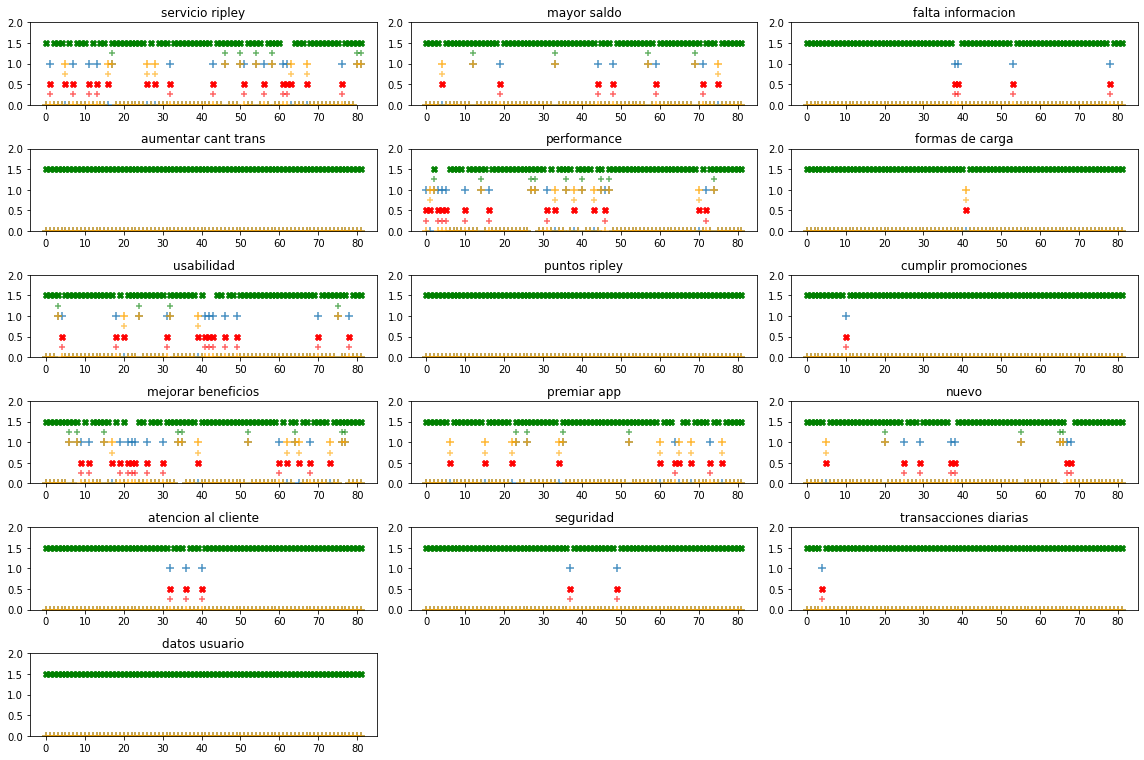

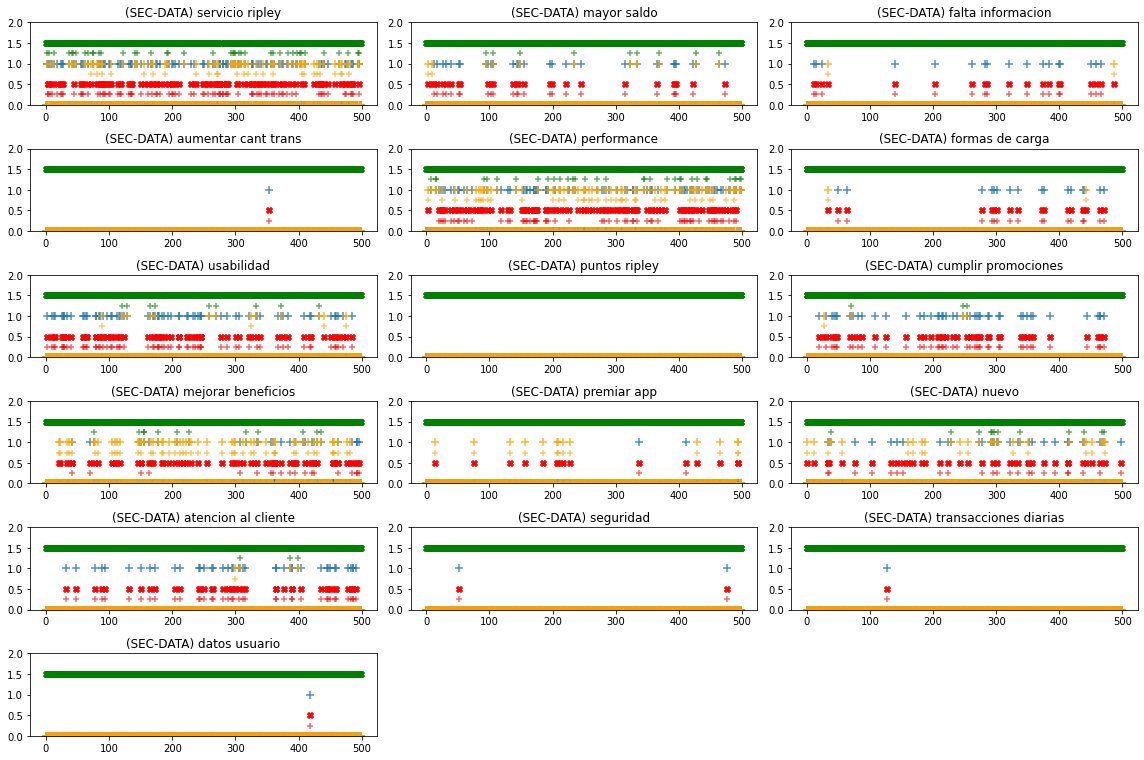

In [16]:
import matplotlib.pyplot as plt
import numpy as np

figFolder = './results/'

def singlePrediction(axs,data,name):
    xPos = range(len(data['prediction']))
    axs.scatter(xPos,data['truth'],marker='+',alpha=.8,s=80)
    axs.scatter(xPos,data['prediction'], facecolor='orange', marker='+',alpha=.8,s=80)
    axs.scatter(xPos,2*(data['truth'] == data['prediction'])-.5, facecolor='g', marker='X')
    axs.scatter(xPos,1.5*(data['truth'] * data['prediction'])-.25, facecolor='g', marker='+',alpha=.6)
    axs.scatter(xPos,0.5*(data['truth'] > data['prediction'])-.25, facecolor='r', marker='+',alpha=.6)
    axs.scatter(xPos,1.0*(data['truth'] < data['prediction'])-.25, facecolor='orange', marker='+',alpha=.6)
    dPos = np.array(data['truth'] != data['prediction'],dtype='int')
    axs.scatter(xPos,dPos-0.5, facecolor='r', marker='X')
    axs.set_title(name)
    axs.set_ylim((0,2))

def plotPredictions(exp, useSecondary = False):
    nPlots = len(exp)
    fig, axs = plt.subplots(int(np.ceil(nPlots/3)),3,figsize=(16,2*nPlots/3))

    for i,e in enumerate(exp):
        if useSecondary:
            singlePrediction(axs[int(i/3)][i%3],e['secondaryTest'],'(SEC-DATA) '+e['exp'])
        else:
            singlePrediction(axs[int(i/3)][i%3],e,e['exp'])
            
    fig.delaxes(axs[-1][1])
    fig.delaxes(axs[-1][-1])
    plt.tight_layout()
    
plotPredictions(exp)
plt.savefig(figFolder+experimentsName+'-groundTruth_predictions.png',facecolor='white')
plotPredictions(exp,useSecondary=True)
plt.savefig(figFolder+experimentsName+'-groundTruth_predictions-sec.png',facecolor='white')

##### Plotting learning history

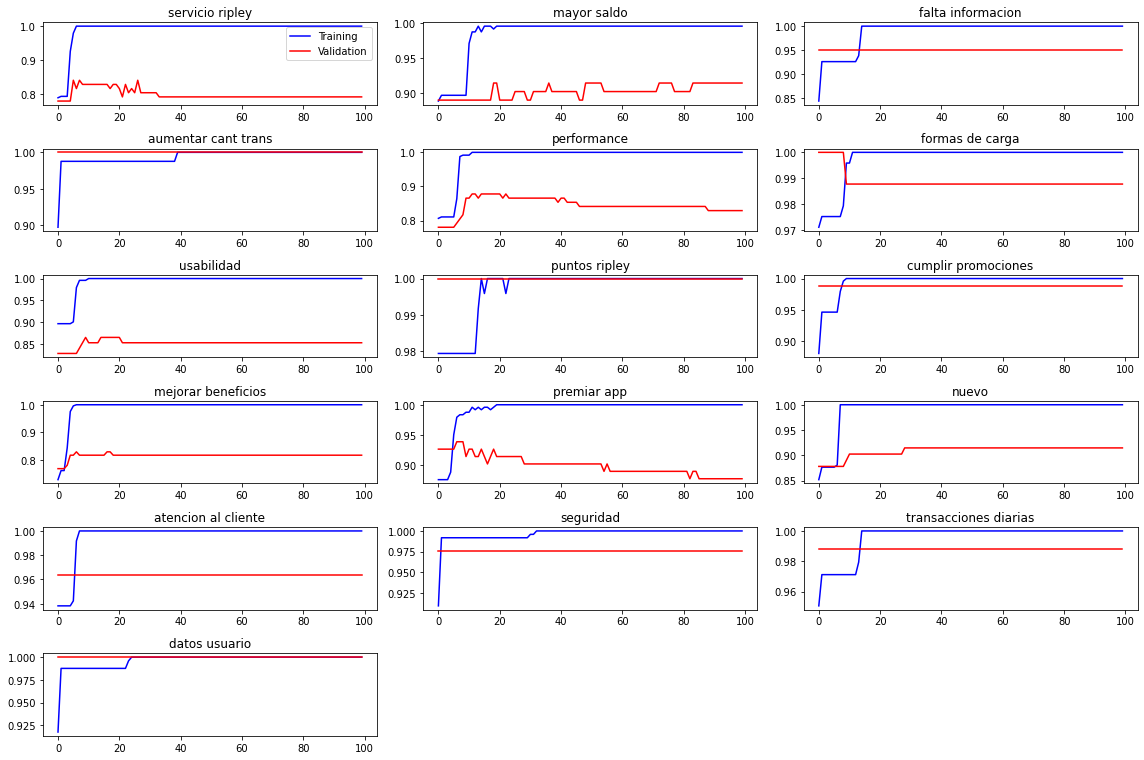

In [17]:
import matplotlib.pyplot as plt
import numpy as np

nPlots = len(exp)
 
def singleHistory(axs,hist,name,useLegend=False):
    xPos = range(len(hist.history['acc']))
    axs.plot(xPos, hist.history['acc'], 'b', label='Training')
    axs.plot(xPos, hist.history['val_acc'], 'r', label='Validation')
    axs.set_title(name)
    if useLegend:
        axs.legend()

fig, axs = plt.subplots(int(np.ceil(nPlots/3)),3,figsize=(16,2*nPlots/3))

for i,e in enumerate(exp):
    singleHistory(axs[int(i/3)][i%3],e['history'],e['exp'],useLegend=(i==0))
        
fig.delaxes(axs[-1][1])
fig.delaxes(axs[-1][-1])
plt.tight_layout()
plt.savefig(figFolder+experimentsName+'-accuracy.png',facecolor='white')